### Quantum scattering on hard wall potential

_ Balint Armin Pataki _  
_ Eotvos Lorand University, Budapest _

In [1]:
import scipy.sparse as spar
import scipy.sparse.linalg as sparLin
import time
import scipy.special as spec
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors

%matplotlib inline

In [2]:
def getWaveInit(N, M, cutoffX, cutoffY, k, center, verbose):
    '''
    Provide the initial wave function for our system. Output: matrix psi(x,y) for t=0. 
    A plance wave with a Gauss filter in both directions.
    Parameters:
    N - grid length in X direction.
    M - grid length in Y direction.
    cutoffX - Cutoff length for the Gaussian filter in X direnction.
    cutoffY - Cutoff length for the Gaussian filter in Y direnction.
    k - wavenumber (direction, energy)
    center - X coordinate for the maximum value of the Gauss filter
    verbose - bool, print progress info?
    '''
    if(verbose):
        printState("Initializing Psi")
        
    waveMatrix = np.zeros([N, M], dtype=np.complex128)
    
    for x in range(N):
        for y in range(M): # there is no norm for the psi
            waveMatrix[x, y] =  np.exp(-1j*k*x) 
            waveMatrix[x, y] *= np.exp(-(x-center)*(x-center)/(cutoffX*cutoffX))
            waveMatrix[x, y] *= np.exp(-(y-int(M/2))*(y-int(M/2))/(cutoffY*cutoffY))
    return waveMatrix

In [3]:
def transformWavetoVector(psi):
    '''
    Transform the wave functon from the matrix form to the vector form.
    Convention: [[a00 a01],[a10 a11]] --> [a00 a01 a10 a11]
    '''
    return np.asarray(psi).reshape(-1)

In [4]:
def transformWavetoMatrix(psi, N, M):
    '''
    Transform the wave functon from the vector form to the matrix form. The matrix will be N x M.
    Parameters:
    N - matrix's first dimension.
    M - matrix's second dimension.
    '''
    return np.reshape(psi, (N, M))

In [5]:
def dispersion(a, m, t, x, x0, hbar=1):
    '''
    Quantum mechanical Gaussain wave packet (exp(-r*r/2a)) at time=t.
    Return value is the probability at (t, x)
    '''
    
    res1 = pow(a/np.sqrt(a*a + np.square(hbar*t/m)), 3)
    res2 = np.exp(-(np.square(x-x0)*a)/(a*a + np.square(hbar*t/m)))
    
    return res1*res2

In [6]:
def plot1Dwavefunction(psi, norm = True, ylim = 0.2, save = False, 
                       fileName = None, title = None, dispersionVar = None):
    '''
    Producing 1D plot for the wave function. 
    Parameters:
    psi - wave function in matrix form
    norm - bool, if norm the wave function for the plot
    ylim - max y value for the plot. it is fixed for the GIFs
    save - bool, if save the plot to file
    fileName - string, name of the file (from the actual directory)
    title - string, title of the plot
    '''
    yData = [0.0] * len(psi)
    y = int(len(psi[0])/2)
    for i in range(len(psi)):
        yData[i] = np.square(np.absolute(psi[i, y]))
    xData = np.linspace(0, len(yData)-1, len(yData))
            
    if(norm):
        yData = yData/sum(yData)
            
    fig = plt.figure()
    plt.xlabel("x dimension")
    plt.ylabel("|Psi|^2")
    plt.ylim([0, ylim])
    
    plt.title(title)
    plt.plot(xData, yData, color='r')
    
    if(dispersionVar != None):
        for j in dispersionVar['t']:
            tDisp = []
            for i in range(len(xData)):
                tmp = dispersion(x=xData[i], x0=dispersionVar['x0'], t=j, m=dispersionVar['m'], a=dispersionVar['a'])
                tDisp.append(tmp)
            if(norm):
                tDisp = tDisp/sum(tDisp)
            plt.plot(xData, tDisp, color='b')
    
    if(not save):
        plt.show()
    else:
        plt.savefig(fileName)

In [7]:
def plotWavefunction(psi, interpol='bicubic', norm = True, save = False, plotLog = False,
                     fileName = None, title = None, extraDraw = None, plotOnlyRight = False, rightValue = None):
    '''
    Producing 2D heatmap plot for the wave function. 
    Parameters:
    psi - wave function in matrix form
    interpol - string, interpolation for the heatmap colours
    norm - bool, if norm the wave function for the plot
    save - bool, if save the plot to file
    fileName - string, name of the file (from the actual directory)
    title - string, title of the plot
    extraDraw - dictionary for drawing the potential walls
    '''
    plotMatrix = np.zeros([len(psi), len(psi[0])], dtype=np.float64)
    for x in range(len(psi)):
        for y in range(len(psi[0])):
            plotMatrix[x,y] = np.square(np.absolute(psi[x, y]))
            if(plotOnlyRight):
                if(x < rightValue):
                    plotMatrix[x,y] = 0.0
         
    plotMatrix = np.transpose(plotMatrix)
    if(norm):
        plotMatrix = plotMatrix/sum(sum(plotMatrix))  # norm psi to 1
    
    fig, ax = plt.subplots()
    plt.rcParams['figure.figsize'] = (10, 6)
    
    if(extraDraw['name'] == 'circle'):
        circle = plt.Circle((extraDraw['x'], extraDraw['y']), radius = extraDraw['r'], color='b', fill=False)
        ax.add_artist(circle)
    if(extraDraw['name'] == 'rectangle'):
        ax.add_patch(patches.Rectangle((extraDraw['xMin'], extraDraw['yMin']),
                                       extraDraw['xMax'] - extraDraw['xMin'],
                                       extraDraw['yMax'] - extraDraw['yMin'], color='b', fill=False))
    if(extraDraw['name'] == 'doubleSlit'):
        ax.add_patch(patches.Rectangle((extraDraw['wallXmin'], -1),
                                       extraDraw['wallXmax'] - extraDraw['wallXmin'],
                                       min(extraDraw['y1Min'], extraDraw['y2Min']), color='b', fill=False))
        ax.add_patch(patches.Rectangle((extraDraw['wallXmin'], min(extraDraw['y1Max'], extraDraw['y2Max'])),
                                       extraDraw['wallXmax'] - extraDraw['wallXmin'],
                                       max(extraDraw['y1Min'], extraDraw['y2Min']) - min(extraDraw['y1Max'], extraDraw['y2Max']),
                                       color='b', fill=False))
        ax.add_patch(patches.Rectangle((extraDraw['wallXmin'], max(extraDraw['y1Max'], extraDraw['y2Max'])),
                                       extraDraw['wallXmax'] - extraDraw['wallXmin'],
                                       len(psi[0]) - max(extraDraw['y1Max'], extraDraw['y2Max']),
                                       color='b', fill=False))
        
    #plt.rc('text', usetex=True)
    if(plotLog): 
        plt.imshow(plotMatrix, cmap='hot', interpolation=interpol, origin='lower', norm=colors.LogNorm())
    else: 
        plt.imshow(plotMatrix, cmap='hot', interpolation=interpol, origin='lower')
    #plt.title(r'Visualisation of the $|\Psi|^2$')
    plt.title(title)
    plt.colorbar()
    
    if(not save):
        plt.show()
    else:
        plt.savefig(fileName)

In [8]:
def vectorToMatrixHelper(N, M, i):
    '''
    Given a vector. Convert it to an N * M matrix. V[i] = MAT[?, ?]
    vector's indexing: x0y0, x0y1, x0y2, ... x0yM | x1y0, x1y1, ...
    Return the indeces.
    '''
    X = int(i/M)
    Y = i - X*M
    return [X, Y]

In [9]:
def applyPotentialWall(H, eps0, N, M, wP, verbose):
    '''
    Apply the pre-defined potential wall for the given Hamiltoni.
    Paramteres:
    H - Hamiltoni to apply the potential wall on.
    eps0 - Height of the potential wall.
    N - x dimension of the grid
    M - y dimension of the grid
    wP - wall paramteres. Here some pre-defined wall types can be used.
    verbose - bool, print progress info?
    '''
    if(verbose):
        printState('Applying potential wall...')
        printState('Potential wall parameters:' + str(wP))
        
    if(wP['name'] == 'circle'):
        return circlePotential(H = H, eps0 = eps0, N = N, M = M, x = wP['x'], y = wP['y'], r = wP['r'])
    if(wP['name'] == 'rectangle'):
        return rectanglePotential(H = H, eps0 = eps0, N = N, M = M, 
                               xMin = wP['xMin'], xMax = wP['xMax'], yMin = wP['yMin'], yMax = wP['yMax'])
    if(wP['name'] == 'doubleSlit'):
        return doubleSlitPotential(H = H, eps0 = eps0, N = N, M = M,
                                   wallXmin = wP['wallXmin'], wallXmax = wP['wallXmax'],
                                   y1Min = wP['y1Min'], y1Max = wP['y1Max'],
                                   y2Min = wP['y2Min'], y2Max = wP['y2Max'])
    else:
        return None

In [10]:
def circlePotential(H, eps0, N, M, x, y, r):
    dimension = N * M

    for i in range(dimension): 
        [X, Y] = vectorToMatrixHelper(N, M, i) # setting up the circle like potential wall
        if(( np.square(X - x) + np.square(Y - y)) < np.square(r)):
            H[i, i] += eps0

    return H

In [11]:
def rectanglePotential(H, eps0, N, M, xMin, xMax, yMin, yMax):
    dimension = N * M

    for i in range(dimension): 
        [X, Y] = vectorToMatrixHelper(N, M, i)
        if((xMin <= X <= xMax) and (yMin <= Y <= yMax)):
            H[i, i] += eps0

    return H

In [12]:
def doubleSlitPotential(H, eps0, N, M, wallXmin, wallXmax, y1Min, y1Max, y2Min, y2Max):
    dimension = N * M

    for i in range(dimension): 
        [X, Y] = vectorToMatrixHelper(N, M, i)
        if(wallXmin <= X <= wallXmin):
            if(not ((y1Min <= Y <= y1Max) or (y2Min <= Y <= y2Max))):
                H[i, i] += eps0

    return H   

In [13]:
def getHamilton(N, M, eps0, gamma, wallParams, verbose):
    '''
    Provide the Hamiltonian with a given potential wall.
    Parameters:
    N - x dimension of the grid.
    M - y dimension of the grid.
    eps0 - Height of the potential wall.
    gamma - Constant for the laplacian part. planck, square size, mass...
    wallParams - A dictionary that defines potential wall.
    verbose - bool, print progress info?
    '''
    if(verbose):
        printState("Setting up the Hamiltoni")
    
    dimension = N * M
    H = spar.dok_matrix((dimension, dimension), dtype=np.float64)
    
    H = applyPotentialWall(H, eps0, N, M, wP = wallParams, verbose = verbose)
    if(verbose):
        printState('Potential wall applied.')
        
    for i in range(dimension):    
    ##### boundary condition = psi is zero outside
        H[i, i]       -= 4*gamma # u_i,j   ## setting up laplace part of the H
        if((i-1)>=0 and (not (i%M) == 0)): 
            H[i, i-1] += 1*gamma # u_i-1,j
        if((i+1)<dimension and (not (i%M) == (M-1))):
            H[i, i+1] += 1*gamma # u_i+1,j
        if((i+M)<dimension):
            H[i, i+M] += 1*gamma # u_i,j-1
        if((i-M)>=0):
            H[i, i-M] += 1*gamma # u_i,j_1
    if(verbose):
        printState('Hamiltoni finished.')
                    
    return spar.dia_matrix(H)

In [14]:
def printState(message):
    print(time.strftime("%H:%M:%S", time.localtime()) + ' - ' + message)

In [15]:
def timePropagatorHelper(H, psi0, cutoffM, verbose = False):
    '''
    Calculate the T_m|psi> vectors.
    Parameters:
    H - Hamiltonian of the system
    psi0 - Wave function for the time = 0.
    cutoffM - sum(0, cutoffM) for the T_ms.
    verbose - bool, print progress info?
    '''
    
    if(verbose):
        printState("Started calculating eigenvalue...")
    w = sparLin.eigsh(H, return_eigenvectors= False, which='LM', k=1)
    if(verbose):
        printState("Finished eigenvalue.")
        
    hNorm = max(w)
    
    hTilde = H/hNorm
    
    if(verbose):
        printState("Started calculating T_m(H)|psi> ...")
    
    psiList = []
    for i in range(cutoffM):
        if(0 == i):
            psiList.append(psi0)
        if(1 == i):
            psiList.append(-1.j*hTilde.dot(psi0))
        if(1 < i):
            psiList.append(-2.j*hTilde.dot(psiList[-1]) + psiList[-2])
    
    if(verbose):
        printState("Finished calculating T_m(H)|psi>")

    return [psiList, hNorm]

In [16]:
def timePropagator(psiList, t, hNorm):
    '''
    Calculate psi(t) from the pre-calculated T_m|psi> vectors.
    Parameters:
    psiList - the T_m|psi> list
    t - time at which we want the psi(t)
    hNorm - the largest eigenvalue of the Hamiltoni
    '''
    tTilde = t * hNorm
    for i in range(len(psiList)):
        if(0 == i):
            finalPsi = spec.jv(i, tTilde) * psiList[0]
        else:
            tmpPsi = 2. * spec.jv(i, tTilde) * psiList[i]
            finalPsi = np.add(finalPsi, tmpPsi)
            
    return finalPsi

# Results

# 2D dispersion

21:09:12 - Initializing Psi
21:09:12 - Setting up the Hamiltoni
21:09:12 - Applying potential wall...
21:09:12 - Potential wall parameters:{'y': 100, 'name': 'circle', 'x': 50, 'r': 0.0}
21:09:13 - Potential wall applied.
21:09:19 - Hamiltoni finished.
21:09:19 - Started calculating eigenvalue...
21:11:54 - Finished eigenvalue.
21:11:54 - Started calculating T_m(H)|psi> ...
21:11:56 - Finished calculating T_m(H)|psi>
21:11:56 - Started plotting


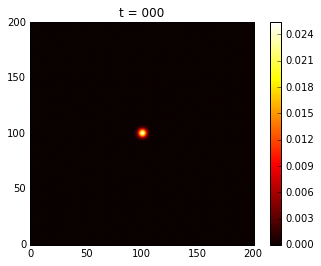

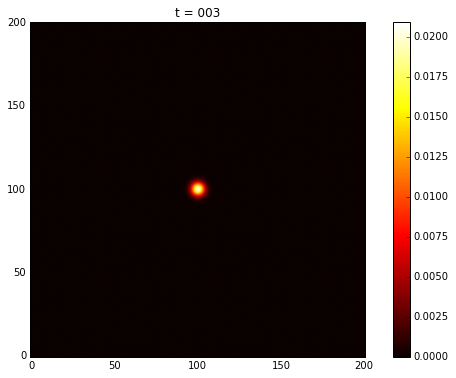

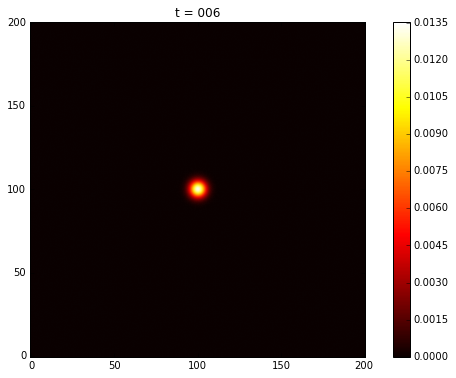

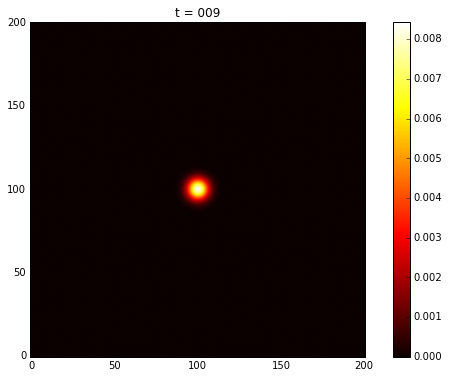

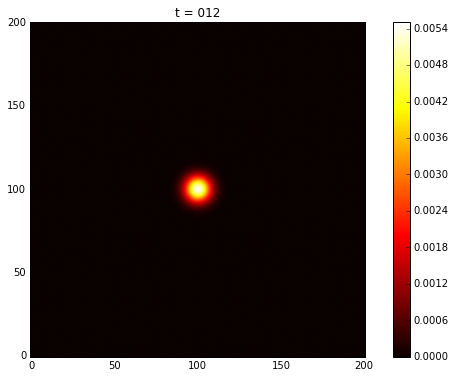

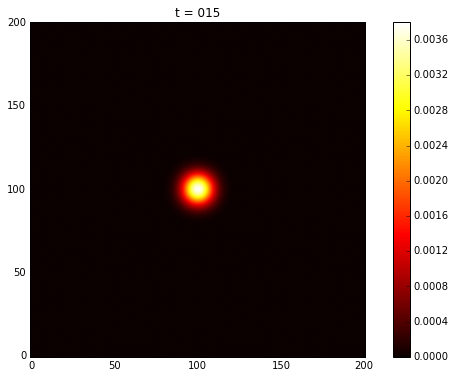

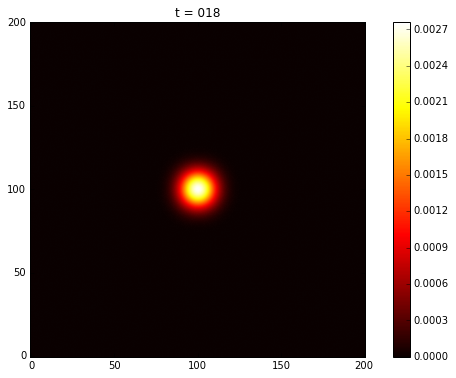

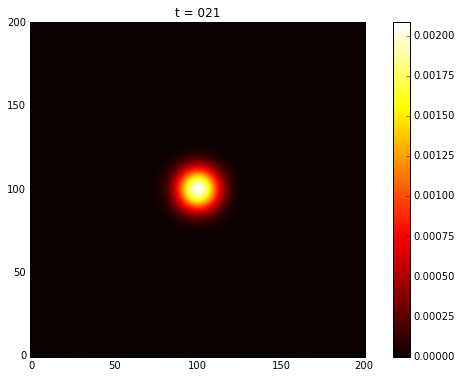

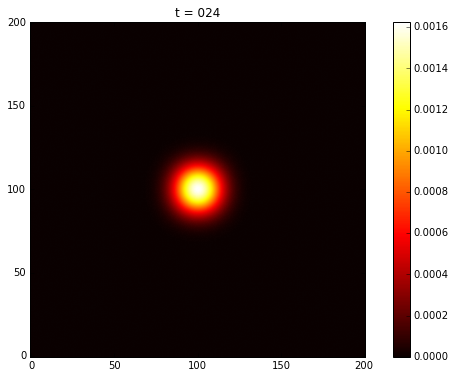

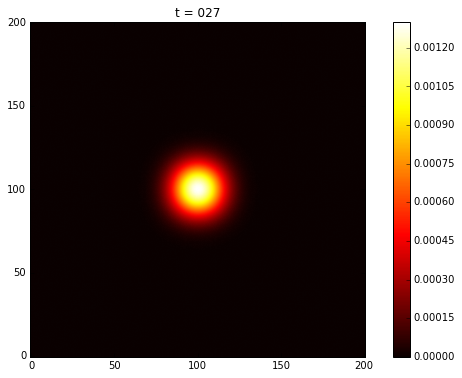

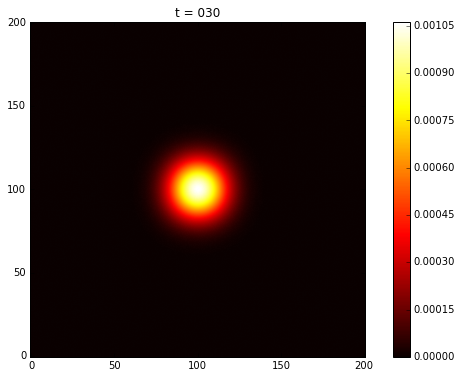

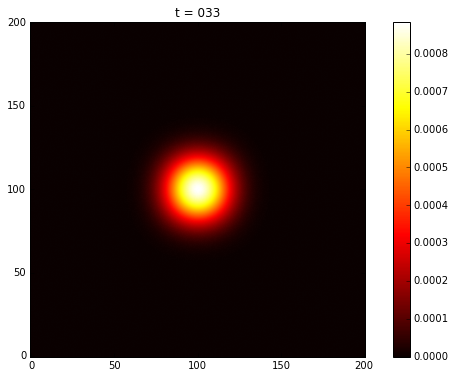

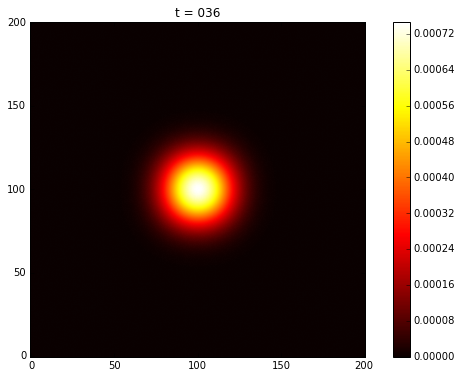

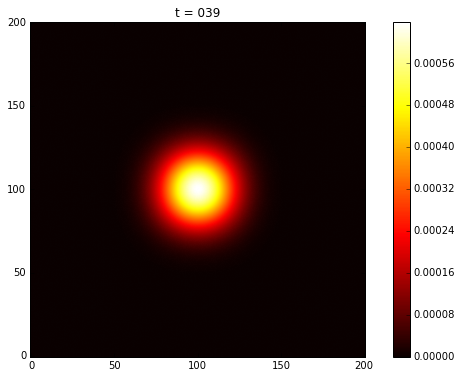

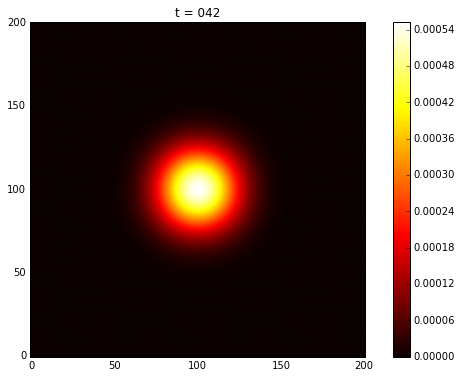

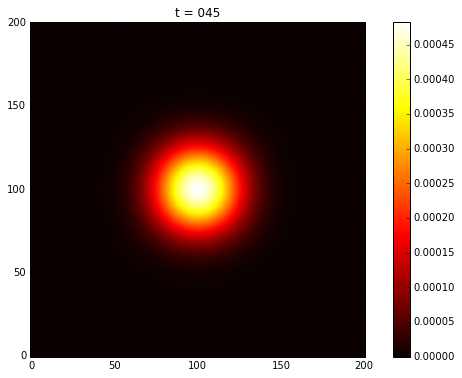

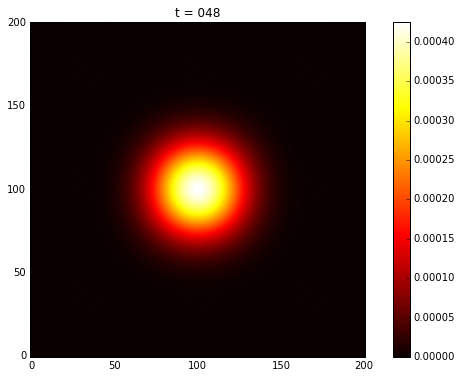

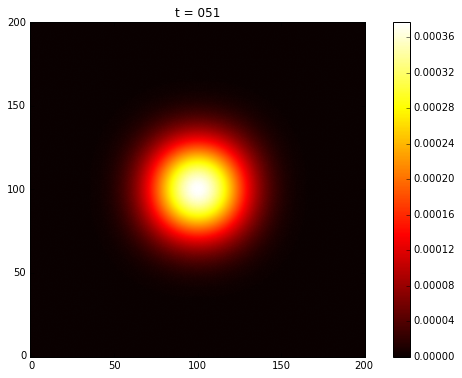

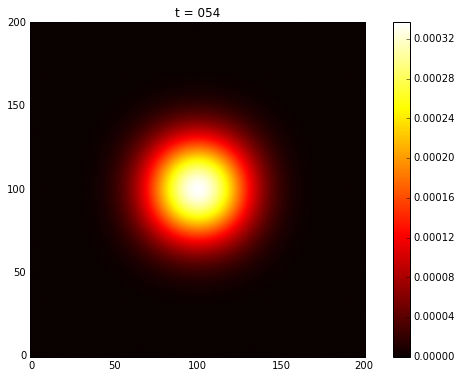

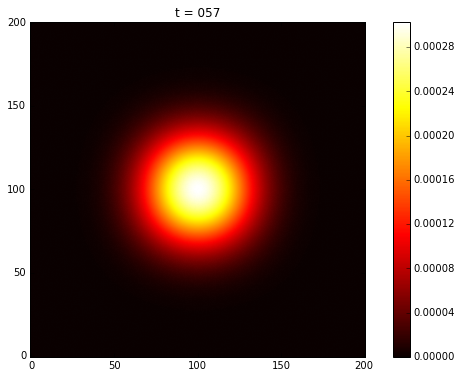

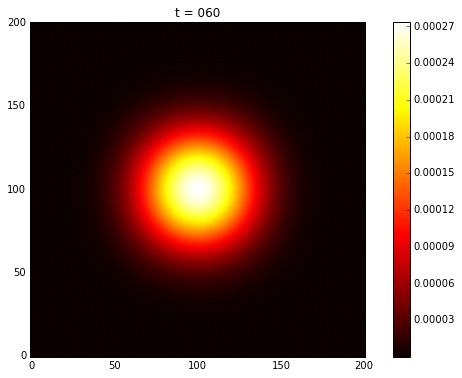

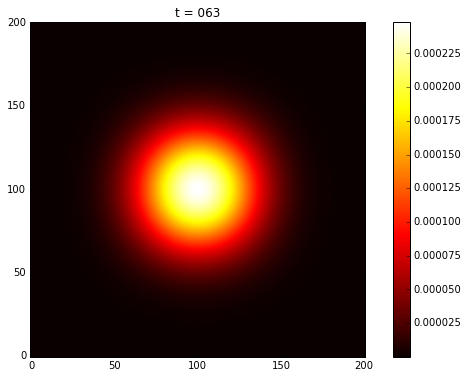

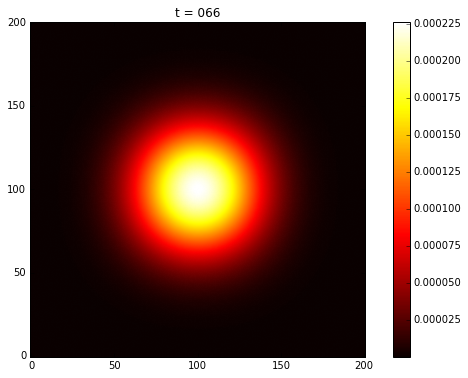

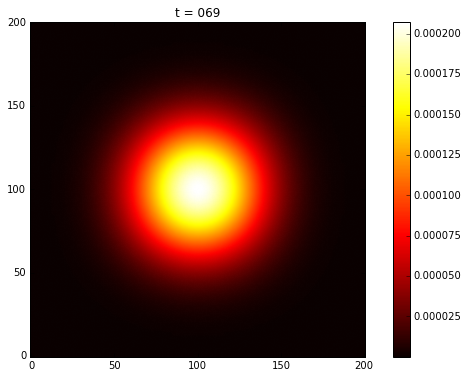

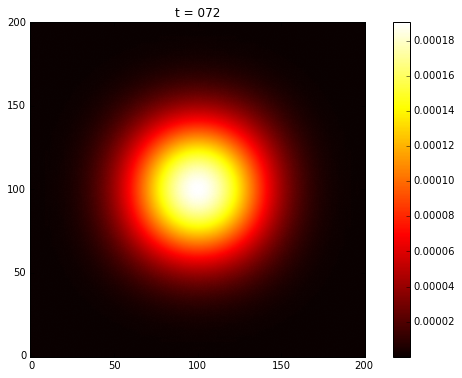

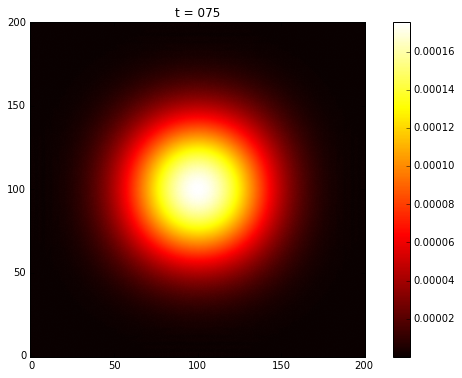

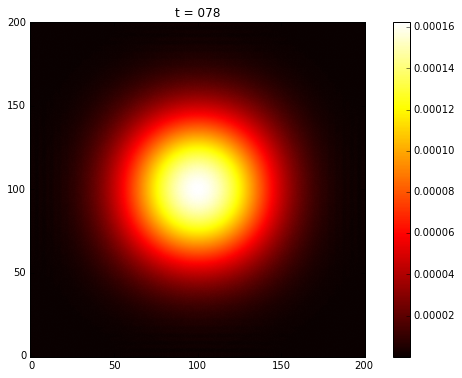

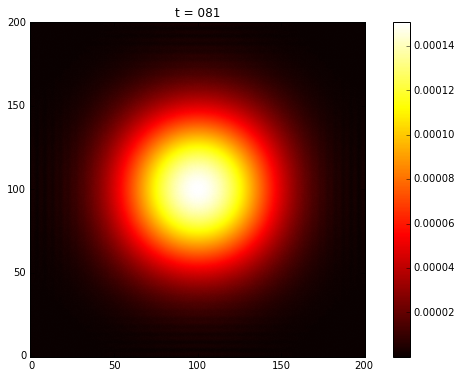

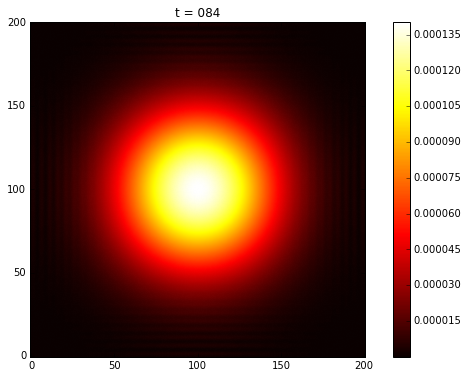

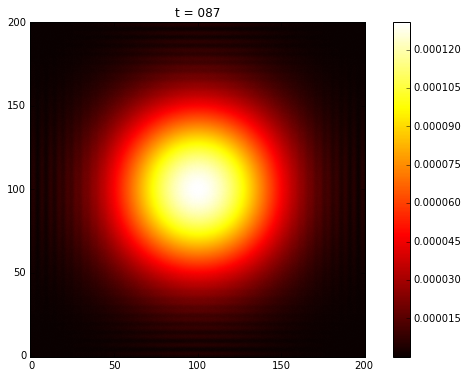

21:12:18 - Finished plotting


In [17]:
N = 201
M = 201
verboseBool = True
normBool = True
potParams = {'name': 'circle', 'x':50, 'y':int(M/2), 'r':0.}
#potParams = {'name': 'rectangle', 'xMin':50, 'xMax':70, 'yMin':30, 'yMax':50}
#potParams = {'name': 'doubleSlit', 'wallXmin':80, 'wallXmax':82, 'y1Min':73, 'y1Max':80, 'y2Min':120, 'y2Max':127}



ps   = getWaveInit(N = N, M = M, cutoffX = 5, cutoffY = 5, k = 0, center = 100, verbose = verboseBool)
hami = getHamilton(N = N, M = M, eps0 = 10., gamma = -1., wallParams = potParams, verbose = verboseBool)
[psList, hNorm] = timePropagatorHelper(hami, transformWavetoVector(ps), cutoffM = 1000, verbose = verboseBool)

printState('Started plotting')

for i in range(30):
    t = 3*i
    evolv = timePropagator(psList, t = t, hNorm = hNorm)     
    plotWavefunction(transformWavetoMatrix(evolv, N, M), norm = normBool, 
                  save = False, fileName="plots/2D_disp_" + str(t).zfill(3) +  ".png",
                  title = "t = " + str(t).zfill(3), extraDraw = potParams)

printState('Finished plotting')

# 2D dispersion at y = 0

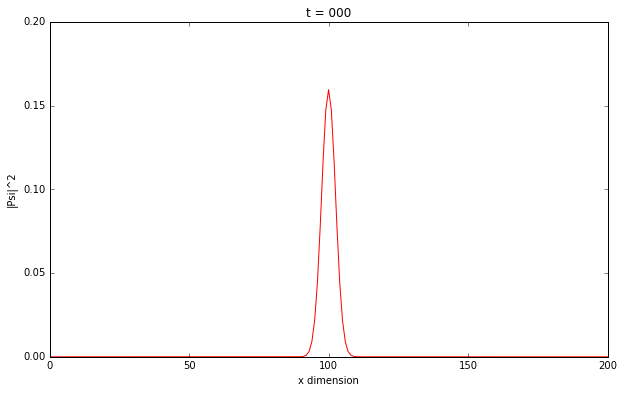

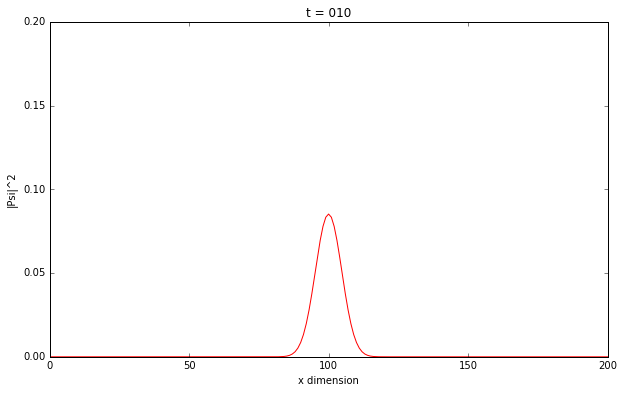

In [18]:
for i in range(2):
    t = i*10
    evolv = timePropagator(psList, t = t, hNorm = hNorm)     
    plot1Dwavefunction(transformWavetoMatrix(evolv, N, M), 
                       save = False, fileName = "plots/1D_disp_" + str(t).zfill(3) +  ".png",
                       title = "t = " + str(t).zfill(3))

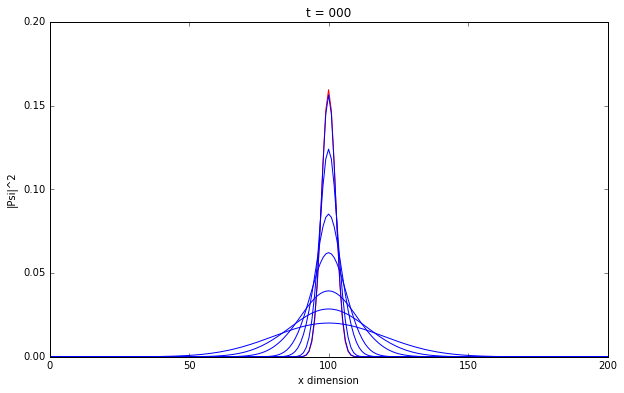

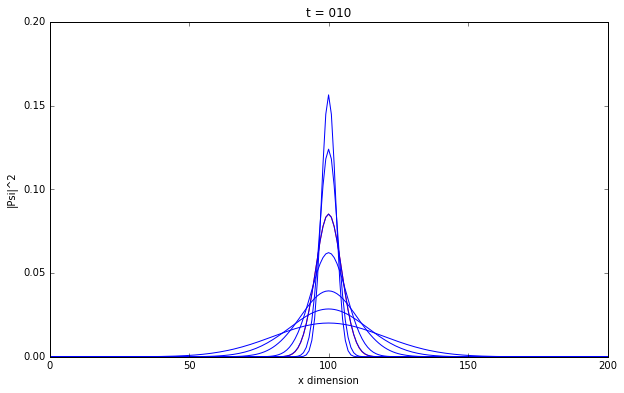

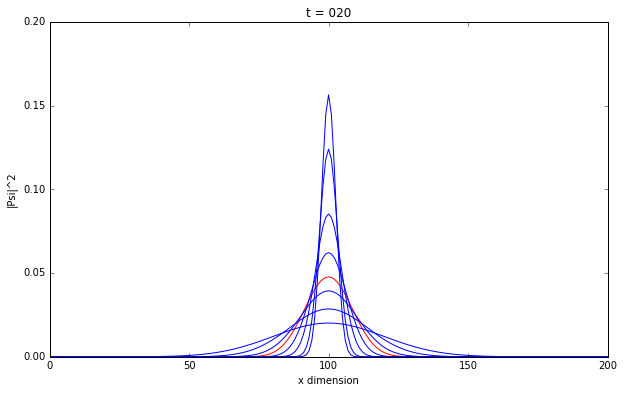

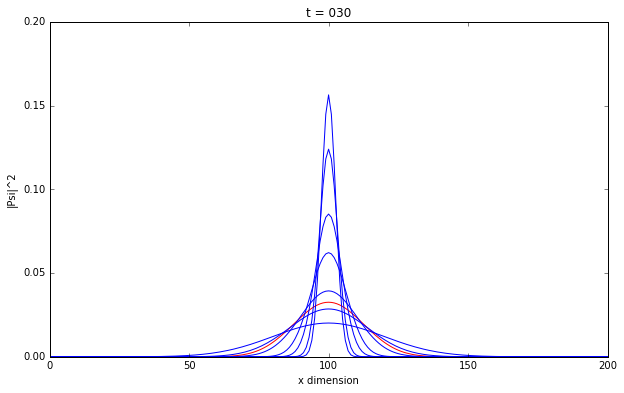

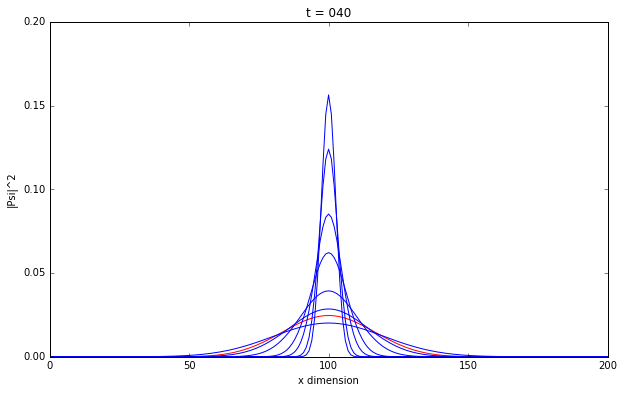

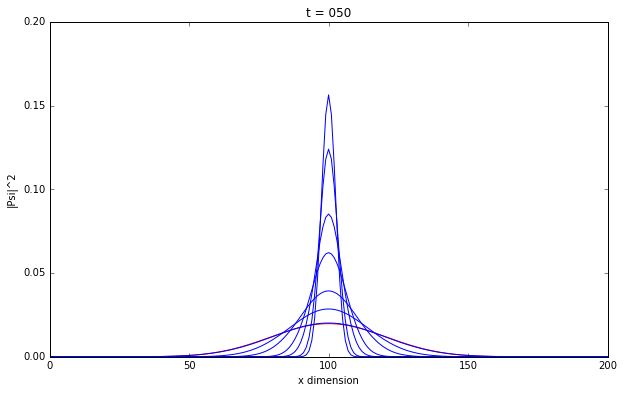

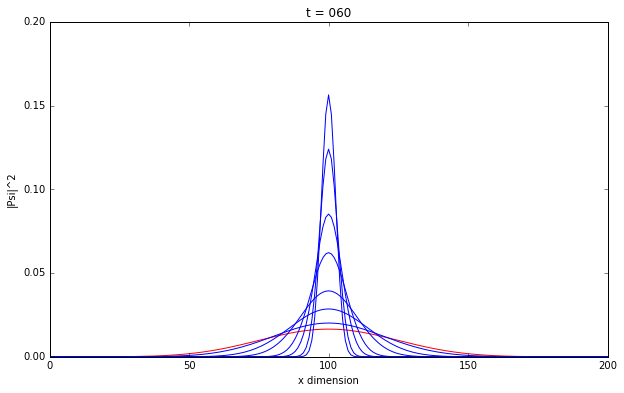

In [19]:
for i in range(7):
    t = i*10
    evolv = timePropagator(psList, t = t, hNorm = hNorm)
    plot1Dwavefunction(transformWavetoMatrix(evolv, N, M), 
                       save = False, fileName = "plots/1D_disp_analytic_" + str(t).zfill(3) +  ".png",
                       title = "t = " + str(t).zfill(3), 
                       dispersionVar={'a':13, 'x0':100, 'm':0.001, 'hbar':1, 
                                      't':[0, 0.01, 0.02, 0.03, 0.05, 0.07, 0.1]})

# Hamiltonian plots

21:12:23 - Initializing Psi
21:12:23 - Setting up the Hamiltoni
21:12:23 - Applying potential wall...
21:12:23 - Potential wall parameters:{'y': 2, 'name': 'circle', 'x': 2, 'r': 1.0}
21:12:23 - Potential wall applied.
21:12:23 - Hamiltoni finished.


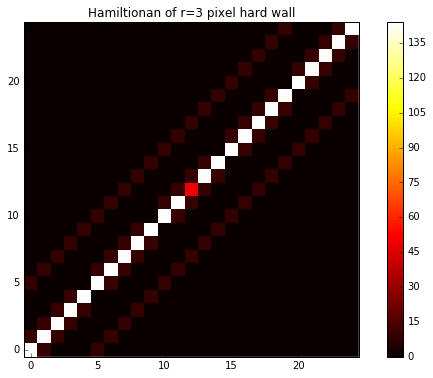

In [20]:
N = 5
M = 5
verboseBool = True
normBool = False

potParams = {'name': 'circle', 'x':int(N/2), 'y':int(M/2), 'r':1.}
#potParams = {'name': 'rectangle', 'xMin':50, 'xMax':70, 'yMin':30, 'yMax':50}
#potParams = {'name': 'doubleSlit', 'wallXmin':80, 'wallXmax':82, 'y1Min':73, 'y1Max':80, 'y2Min':120, 'y2Max':127}


ps   = getWaveInit(N = N, M = M, cutoffX = 20, cutoffY = 50, k = 100, center = 50, verbose = verboseBool)
hami = getHamilton(N = N, M = M, eps0 = 5., gamma = 3., wallParams = potParams, verbose = verboseBool)
#transformWavetoMatrix(evolv, N, M)
plotWavefunction(interpol='none', psi=hami.toarray(), save=False, extraDraw={'name':'None'}, 
                 title='Hamiltionan of r=3 pixel hard wall', norm=False, fileName='n1_hami.png')

# Rectangular potential

21:12:31 - Initializing Psi
21:12:31 - Setting up the Hamiltoni
21:12:31 - Applying potential wall...
21:12:31 - Potential wall parameters:{'yMin': 140, 'xMin': 200, 'name': 'rectangle', 'yMax': 160, 'xMax': 220}
21:12:32 - Potential wall applied.
21:12:44 - Hamiltoni finished.
21:12:45 - Started calculating eigenvalue...
21:12:54 - Finished eigenvalue.
21:12:54 - Started calculating T_m(H)|psi> ...
21:12:57 - Finished calculating T_m(H)|psi>
21:12:57 - Started plotting


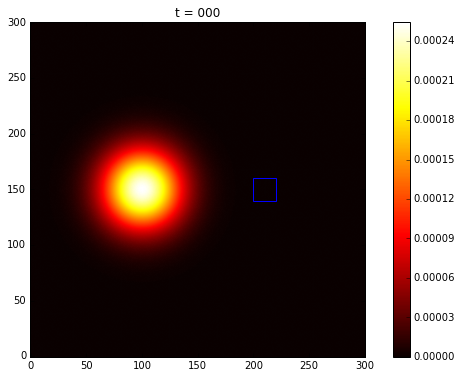

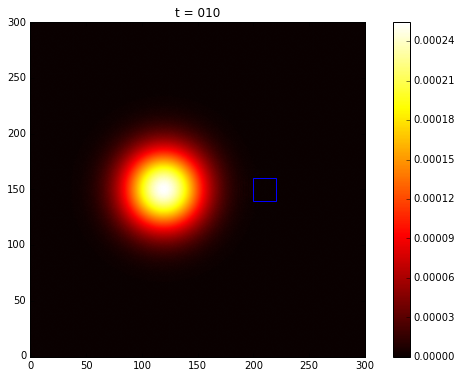

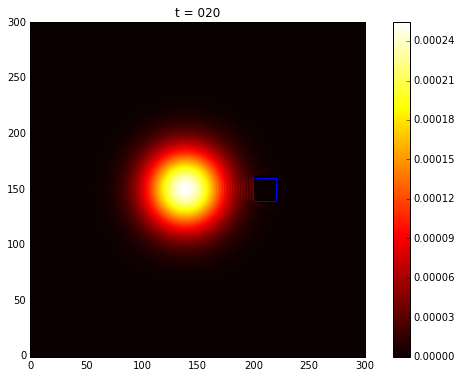

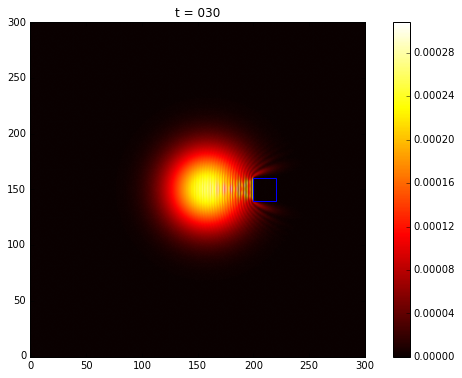

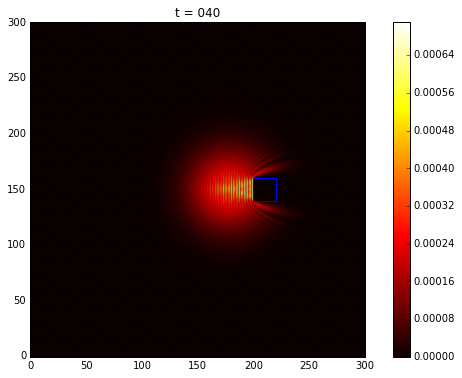

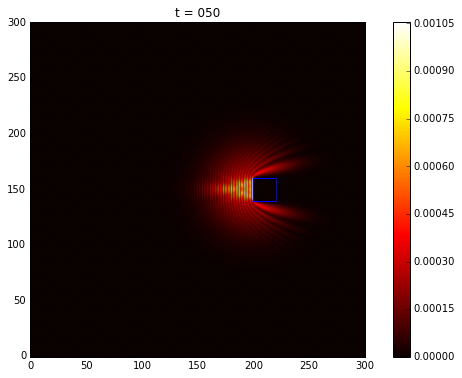

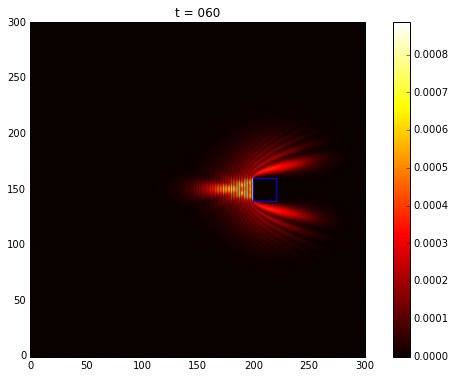

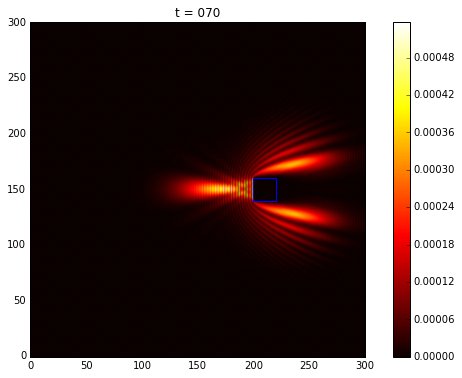

21:13:08 - Finished plotting


In [21]:
N = 301
M = 301
verboseBool = True
normBool = True
#potParams = {'name': 'circle', 'x':50, 'y':int(M/2), 'r':10.}
potParams = {'name': 'rectangle', 'xMin':200, 'xMax':220, 'yMin':140, 'yMax':160}
#potParams = {'name': 'doubleSlit', 'wallXmin':80, 'wallXmax':82, 'y1Min':73, 'y1Max':80, 'y2Min':120, 'y2Max':127}


ps   = getWaveInit(N = N, M = M, cutoffX = 50, cutoffY = 50, k = 250, center = 100, verbose = verboseBool)
hami = getHamilton(N = N, M = M, eps0 = 5., gamma = -1., wallParams = potParams, verbose = verboseBool)
[psList, hNorm] = timePropagatorHelper(hami, transformWavetoVector(ps), cutoffM = 1000, verbose = verboseBool)

printState('Started plotting')

for i in range(8):
    t = 10*i
    evolv = timePropagator(psList, t = t, hNorm = hNorm)     
    plotWavefunction(transformWavetoMatrix(evolv, N, M), norm = normBool, 
              save = False, fileName="plots/rect_" + str(t).zfill(3) +  ".png",
              title = "t = " + str(t).zfill(3), extraDraw = potParams)
    
printState('Finished plotting')

# Cylinder potential

21:13:08 - Initializing Psi
21:13:09 - Setting up the Hamiltoni
21:13:09 - Applying potential wall...
21:13:09 - Potential wall parameters:{'y': 150, 'name': 'circle', 'x': 150, 'r': 10.0}
21:13:09 - Potential wall applied.
21:13:22 - Hamiltoni finished.
21:13:23 - Started calculating eigenvalue...
21:13:30 - Finished eigenvalue.
21:13:30 - Started calculating T_m(H)|psi> ...
21:13:33 - Finished calculating T_m(H)|psi>
21:13:33 - Started plotting


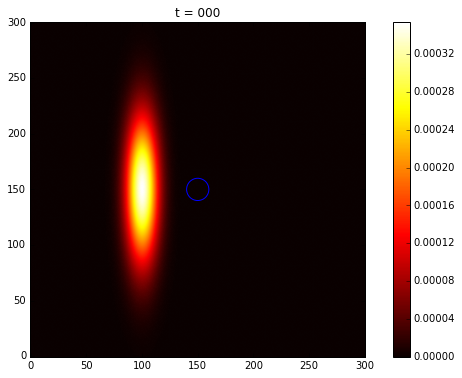

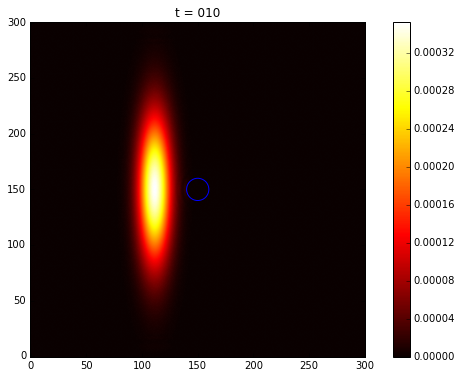

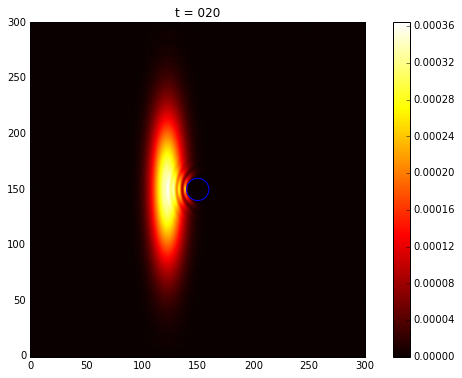

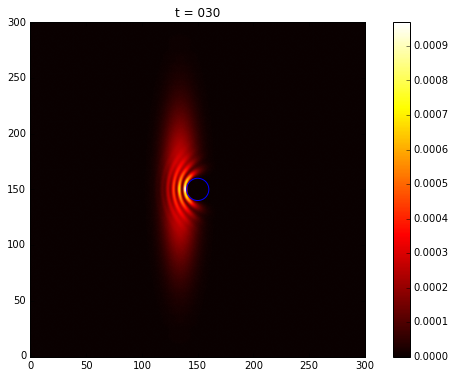

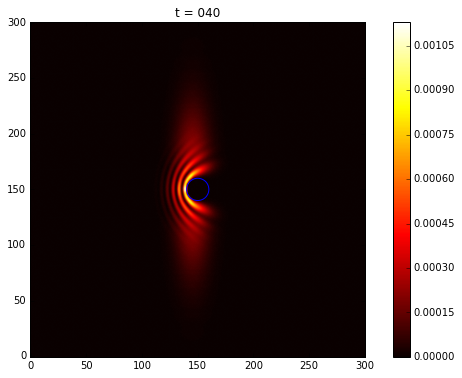

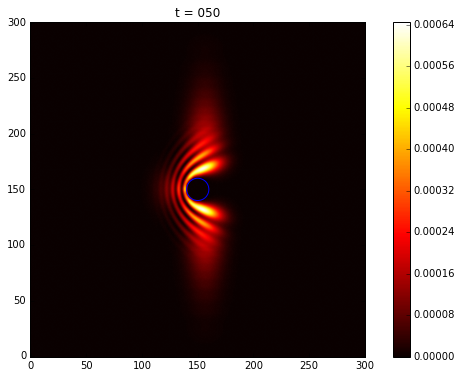

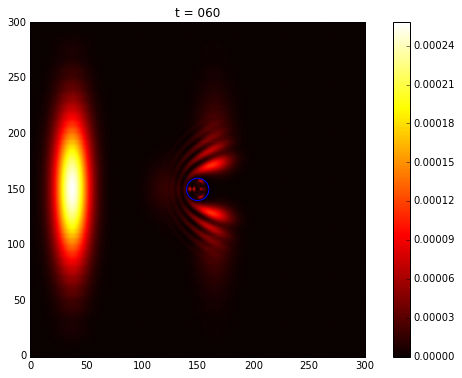

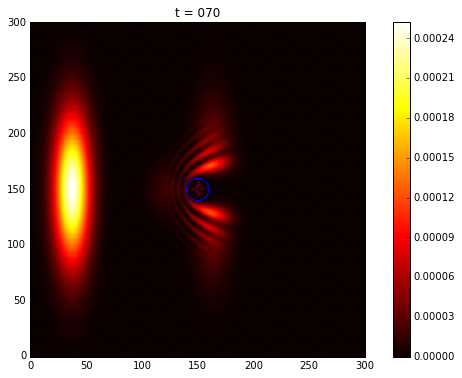

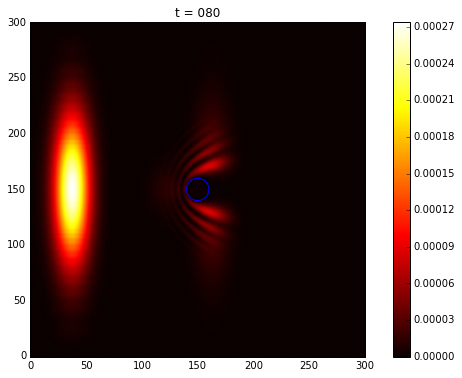

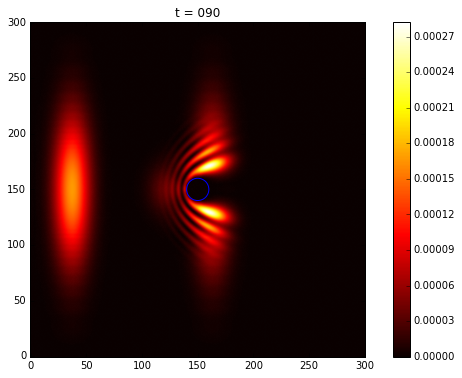

21:13:46 - Finished plotting


In [22]:
N = 301
M = 301
verboseBool = True
normBool = True
potParams = {'name': 'circle', 'x':150, 'y':int(M/2), 'r':10.}
#potParams = {'name': 'rectangle', 'xMin':50, 'xMax':70, 'yMin':30, 'yMax':50}
#potParams = {'name': 'doubleSlit', 'wallXmin':80, 'wallXmax':82, 'y1Min':92, 'y1Max':95, 'y2Min':105, 'y2Max':108}


ps   = getWaveInit(N = N, M = M, cutoffX = 20, cutoffY = 90, k = -0.6, center = 100, verbose = verboseBool)
hami = getHamilton(N = N, M = M, eps0 = 10., gamma = -1., wallParams = potParams, verbose = verboseBool)
[psList, hNorm] = timePropagatorHelper(hami, transformWavetoVector(ps), cutoffM = 1000, verbose = verboseBool)

printState('Started plotting')

for i in range(10):
    t = i*10
    evolv = timePropagator(psList, t = t, hNorm = hNorm)     
    plotWavefunction(transformWavetoMatrix(evolv, N, M), norm = normBool, 
              save = False, fileName="plots/cirlce_" + str(t).zfill(3) +  ".png",
              title = "t = " + str(t).zfill(3), extraDraw = potParams)
    
printState('Finished plotting')

# Double slit

21:13:46 - Initializing Psi
21:13:47 - Setting up the Hamiltoni
21:13:47 - Applying potential wall...
21:13:47 - Potential wall parameters:{'name': 'doubleSlit', 'y2Min': 170, 'wallXmax': 202, 'y1Min': 125, 'y2Max': 175, 'y1Max': 130, 'wallXmin': 200}
21:13:47 - Potential wall applied.
21:14:00 - Hamiltoni finished.
21:14:00 - Started calculating eigenvalue...
21:17:37 - Finished eigenvalue.
21:17:37 - Started calculating T_m(H)|psi> ...
21:17:40 - Finished calculating T_m(H)|psi>
21:17:40 - Started plotting


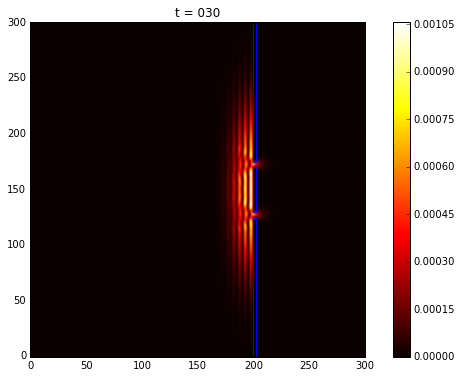

21:17:41 - Finished plotting


In [23]:
N = 301
M = 301
verboseBool = True
normBool = True


#potParams = {'name': 'circle', 'x':150, 'y':int(M/2), 'r':r}
#potParams = {'name': 'rectangle', 'xMin':50, 'xMax':70, 'yMin':30, 'yMax':50}
potParams = {'name': 'doubleSlit', 'wallXmin':200, 'wallXmax':202, 'y1Min':125, 'y1Max':130, 'y2Min':170, 'y2Max':175}


ps   = getWaveInit(N = N, M = M, cutoffX = 20, cutoffY = 90, k = -0.6, center = 160, verbose = verboseBool)
hami = getHamilton(N = N, M = M, eps0 = 10., gamma = -1., wallParams = potParams, verbose = verboseBool)
[psList, hNorm] = timePropagatorHelper(hami, transformWavetoVector(ps), cutoffM = 1000, verbose = verboseBool)

printState('Started plotting')

for i in range(1):
    t = 30
    evolv = timePropagator(psList, t = t, hNorm = hNorm)     
    plotWavefunction(transformWavetoMatrix(evolv, N, M), norm = normBool, 
              save = False, fileName="plots/doubleSlit" + str(t).zfill(3) +  ".png",
              title = "t = " + str(t).zfill(3), extraDraw = potParams)
    
printState('Finished plotting')

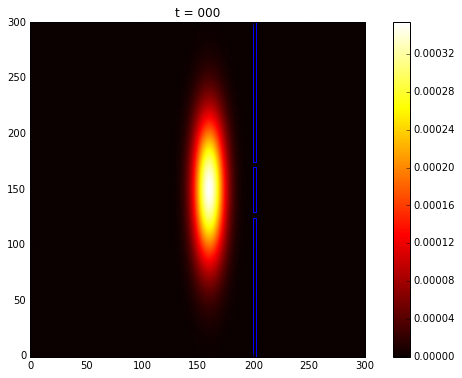

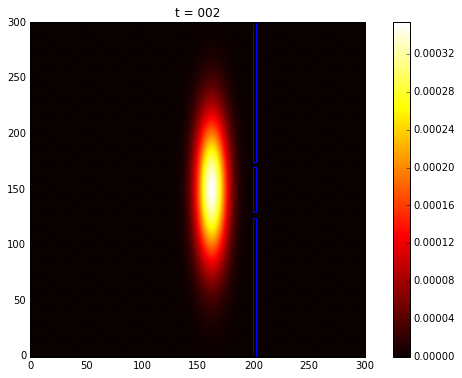

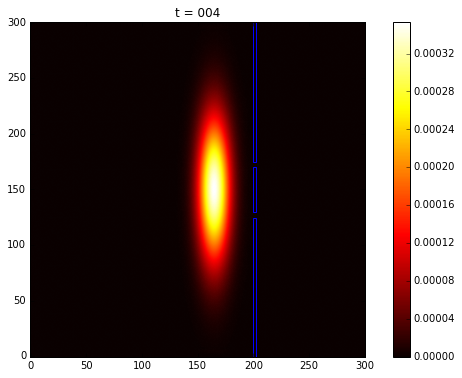

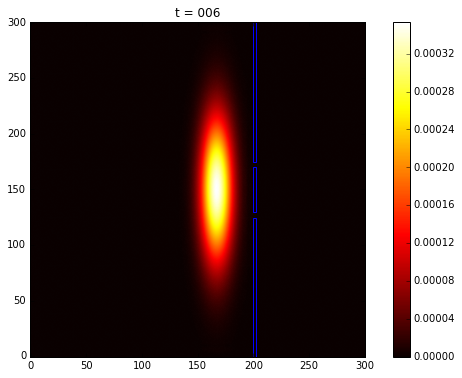

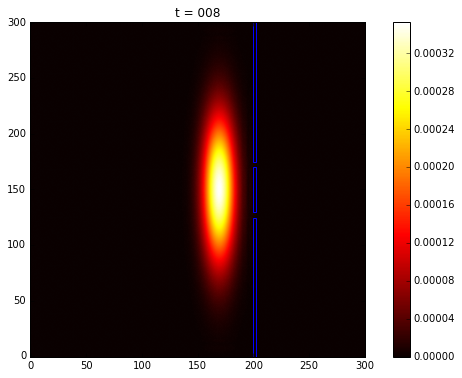

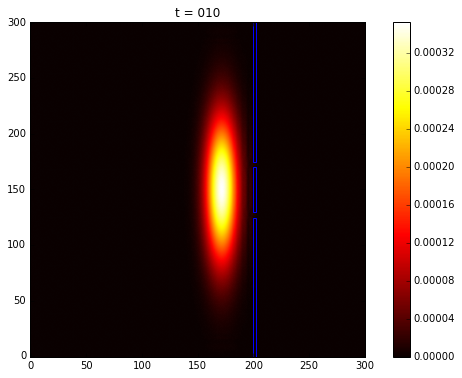

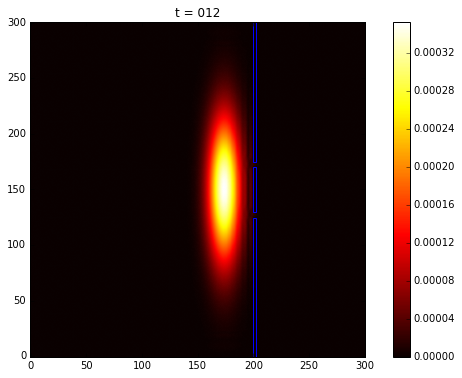

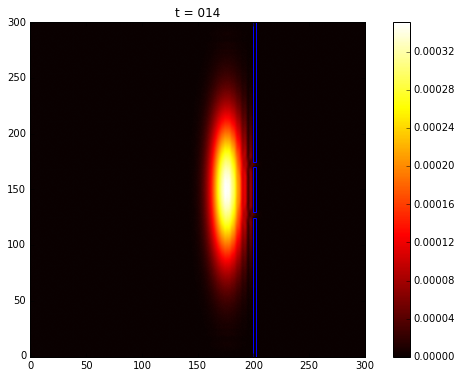

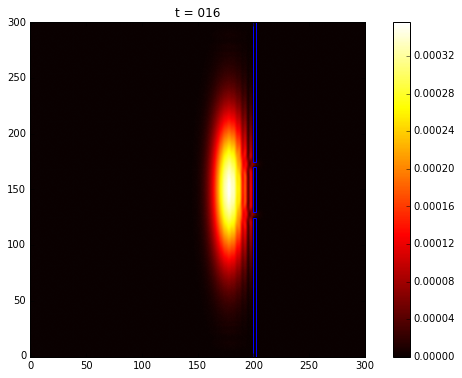

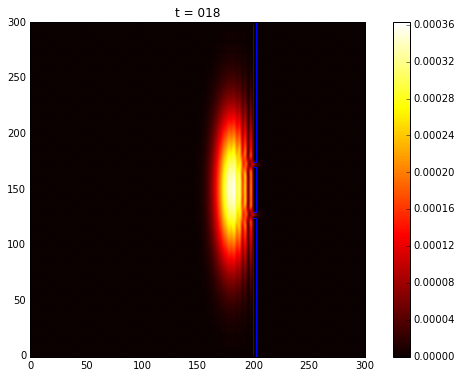

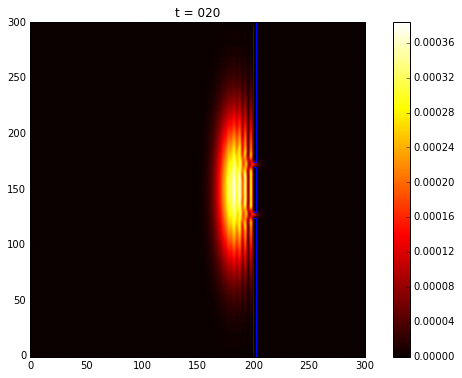

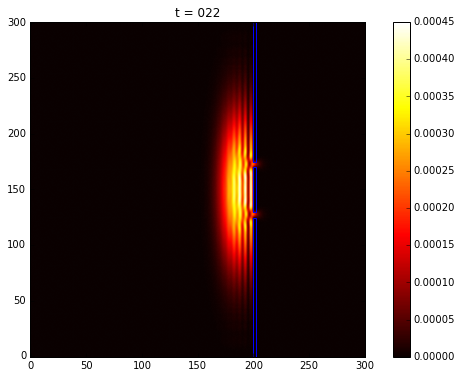

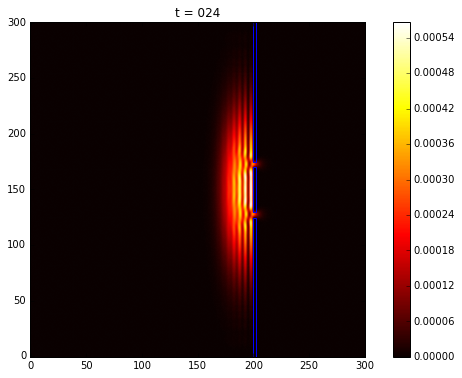

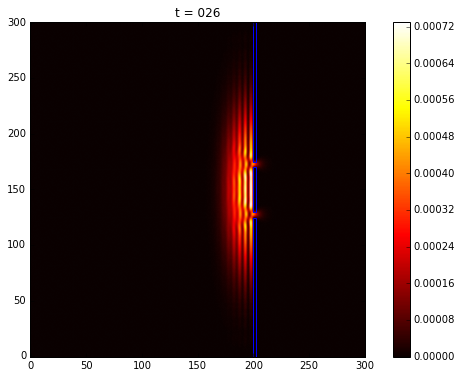

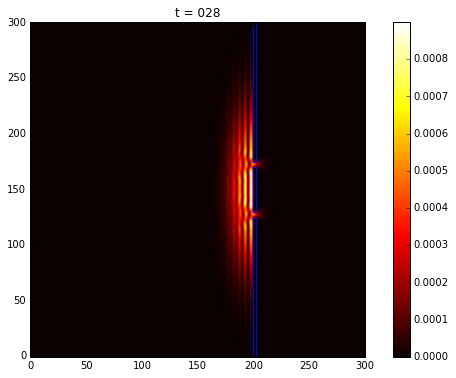

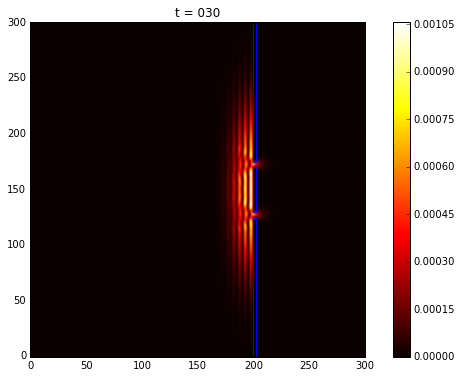

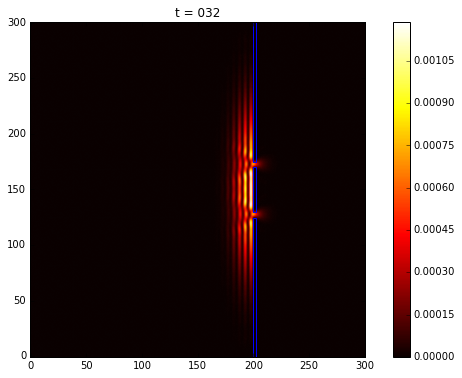

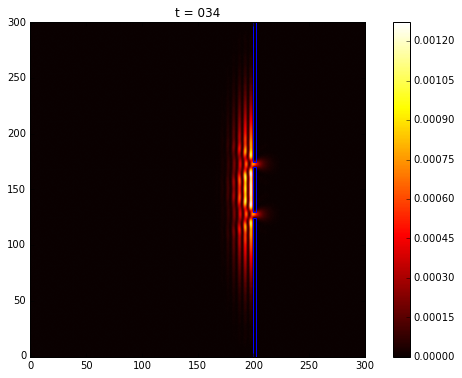

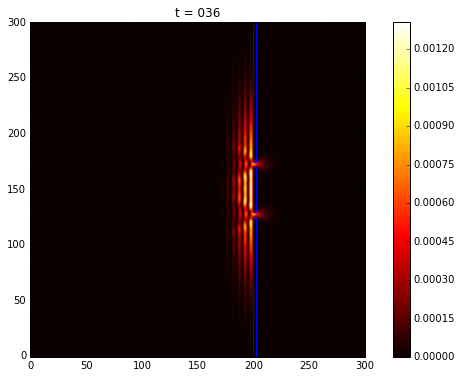

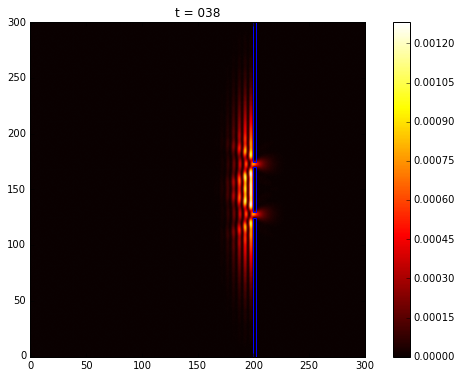

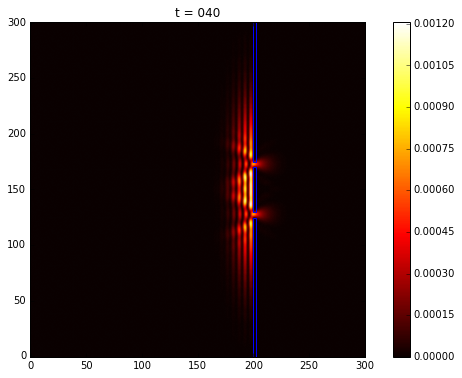

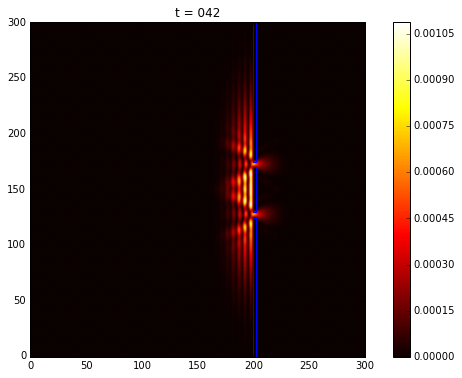

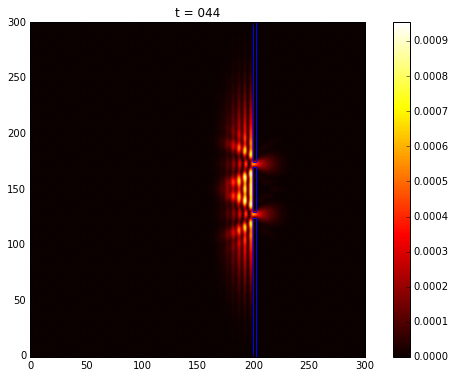

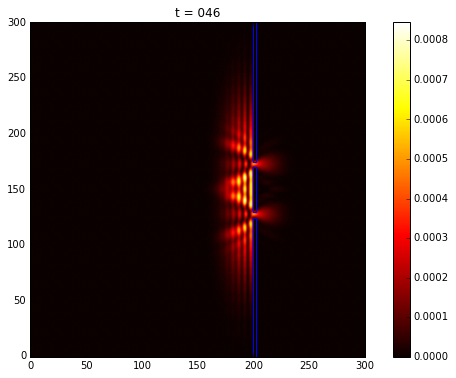

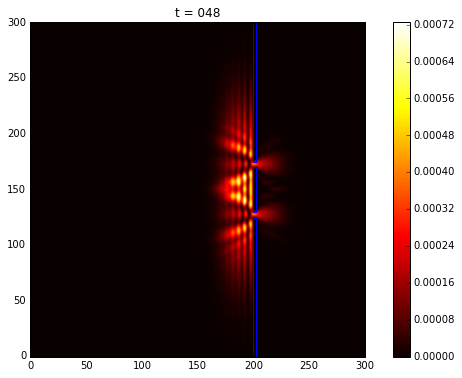

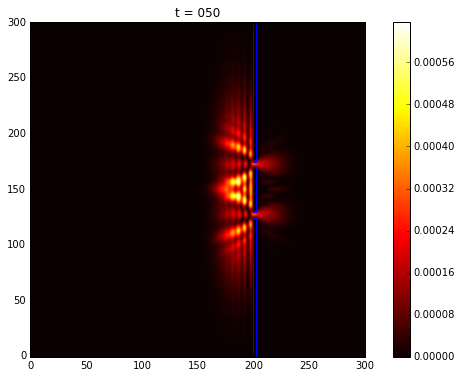

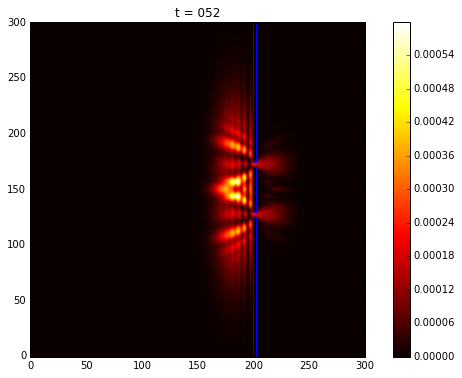

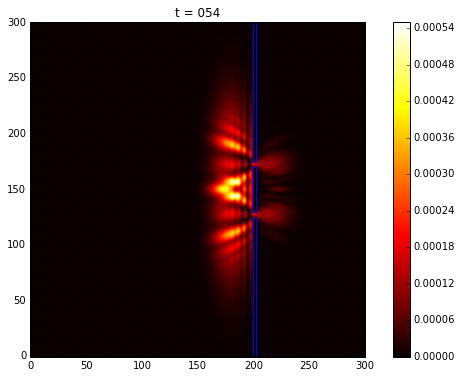

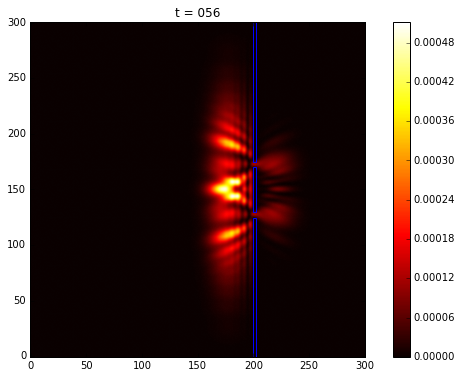

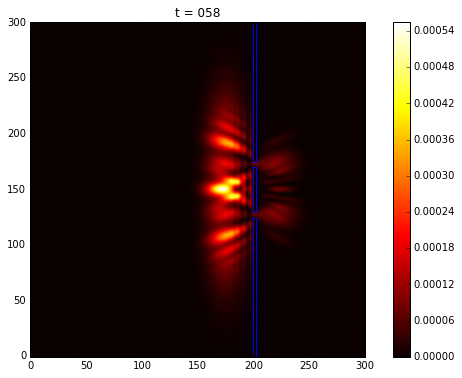

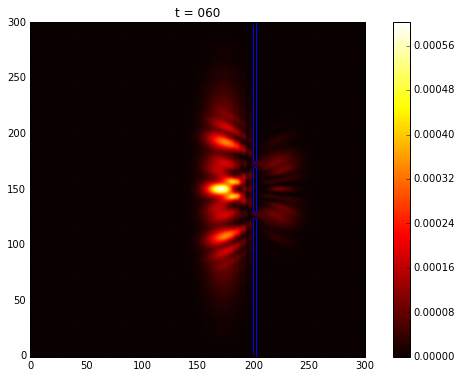

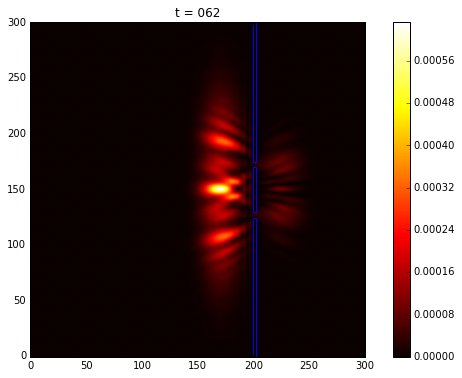

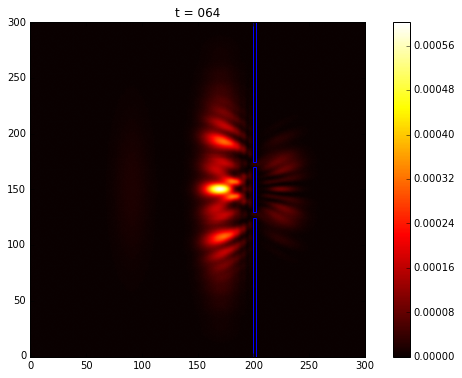

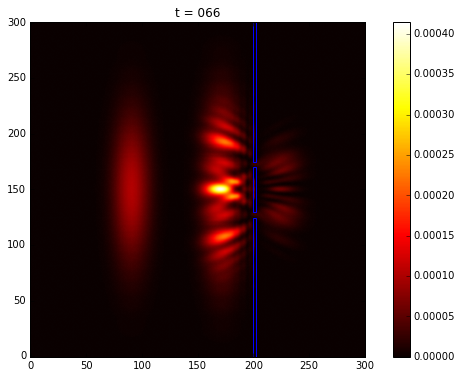

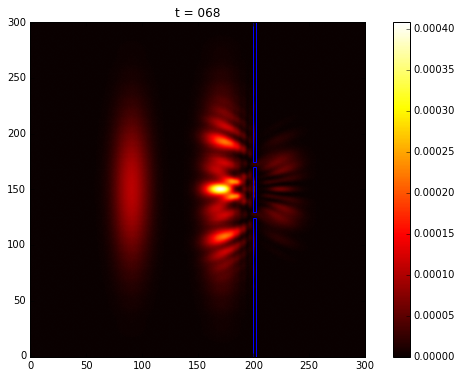

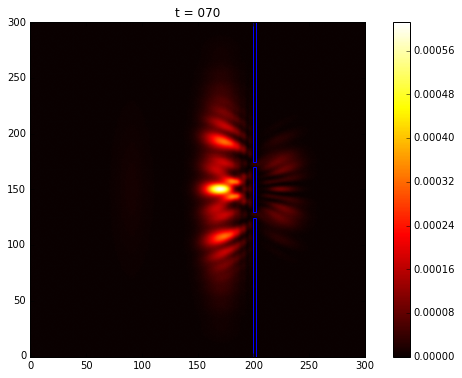

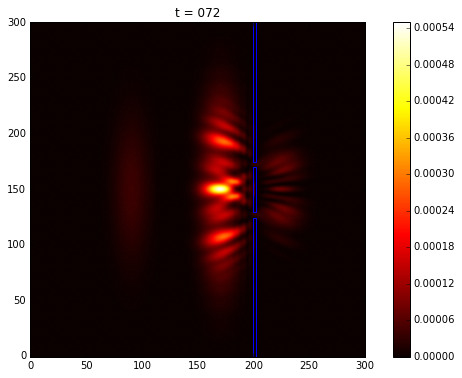

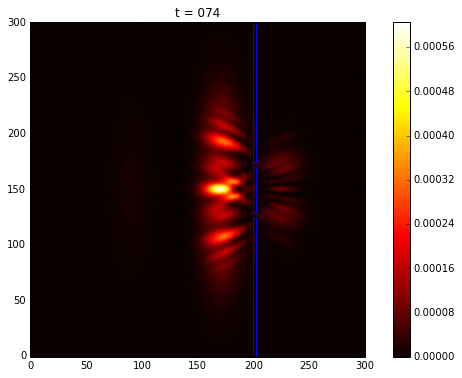

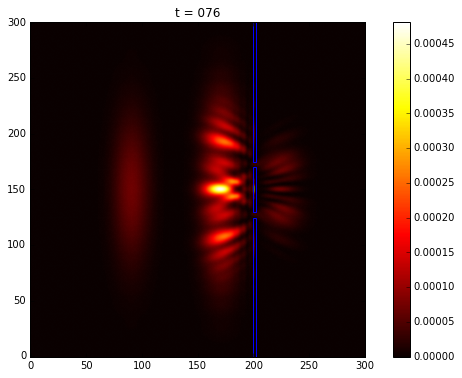

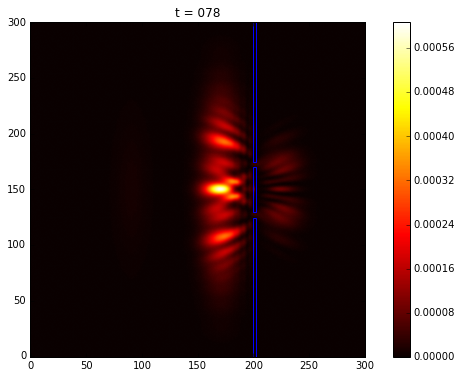

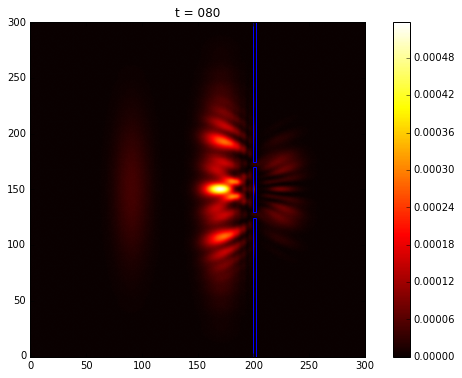

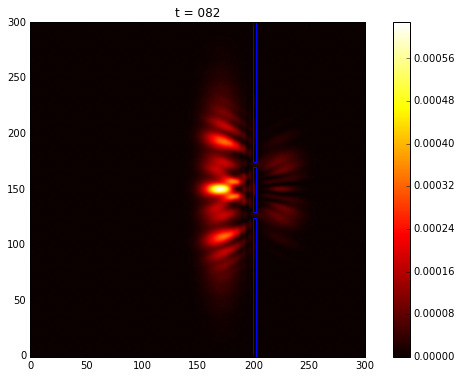

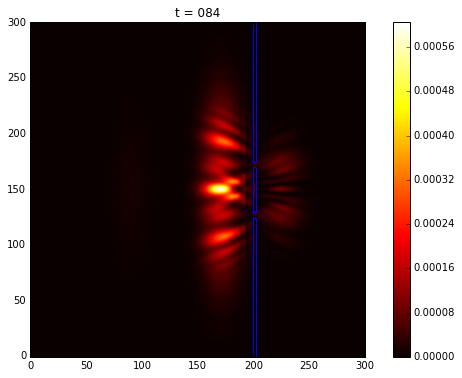

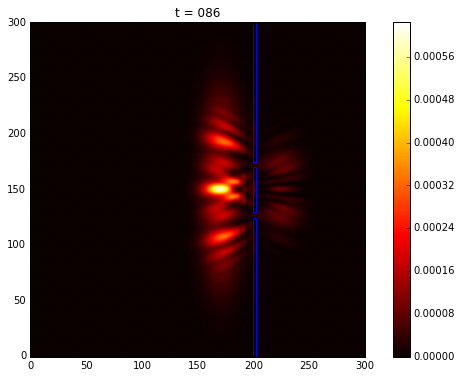

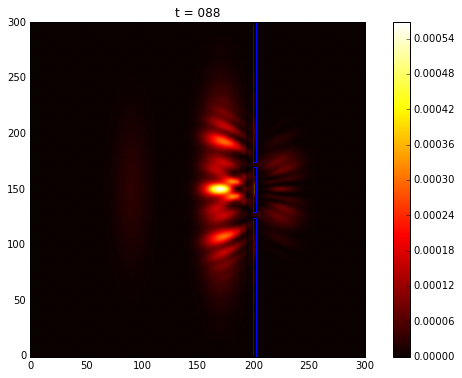

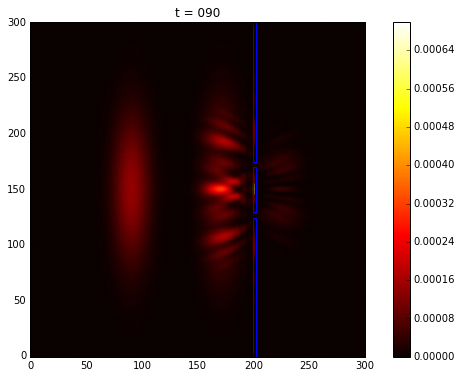

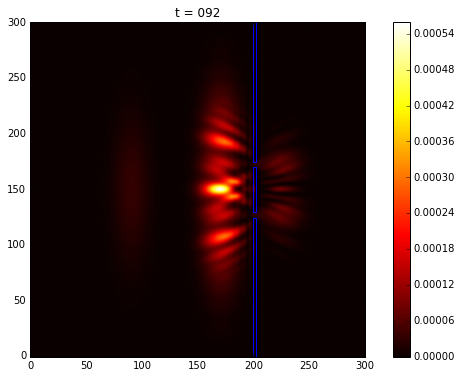

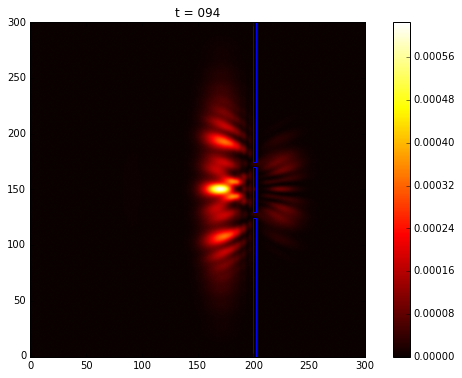

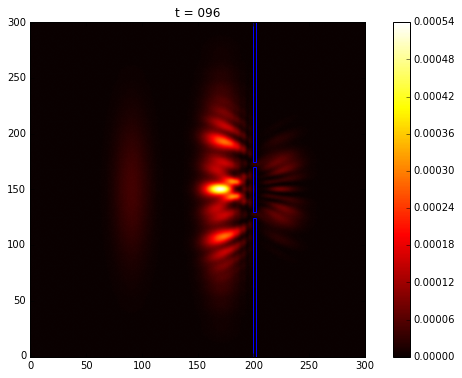

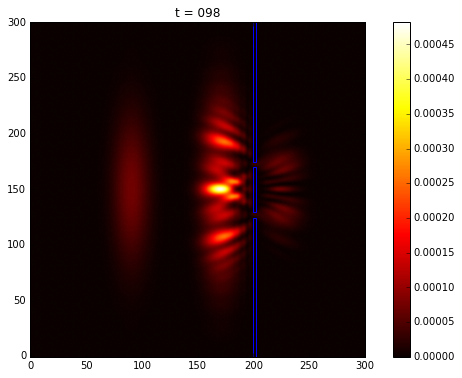

In [24]:
for i in range(50):
    t = i*2
    evolv = timePropagator(psList, t = t, hNorm = hNorm)     
    plotWavefunction(transformWavetoMatrix(evolv, N, M), norm = normBool, 
              save = False, fileName="plots/2doubleSlit_" + str(t).zfill(3) +  ".png",
              title = "t = " + str(t).zfill(3), extraDraw = potParams)

# Log color scale plots

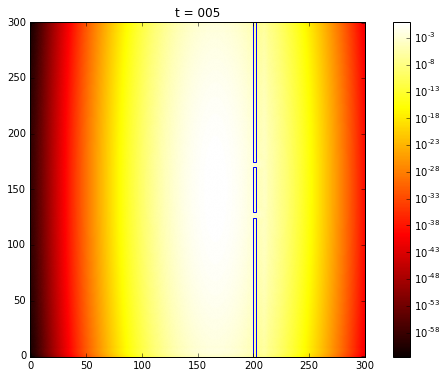

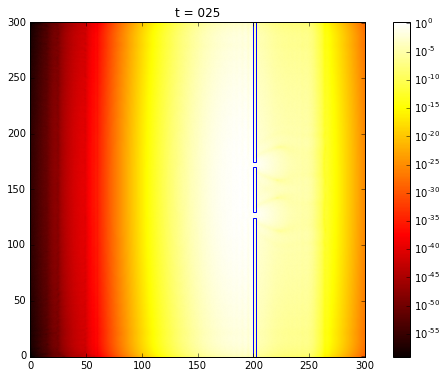

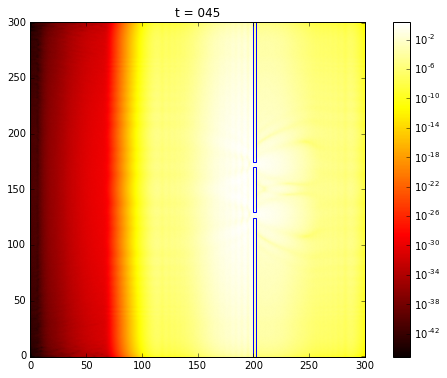

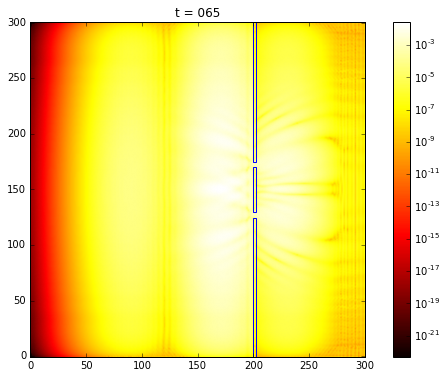

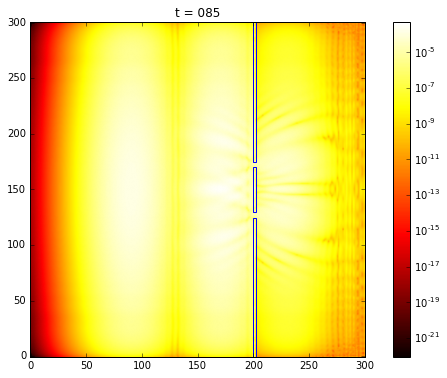

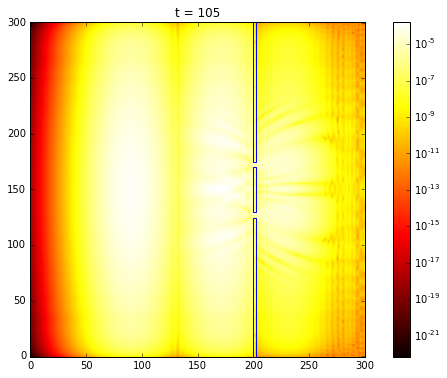

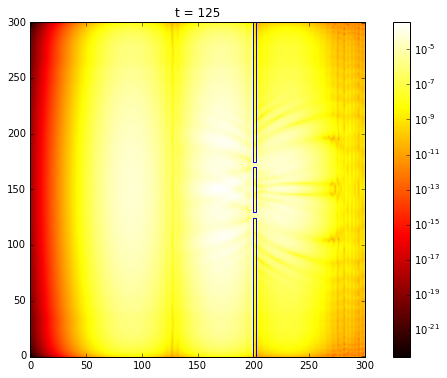

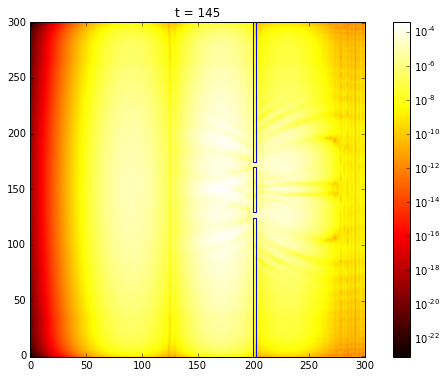

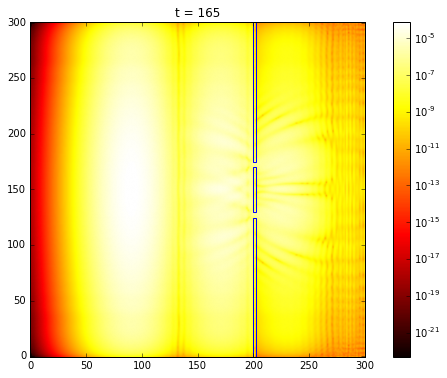

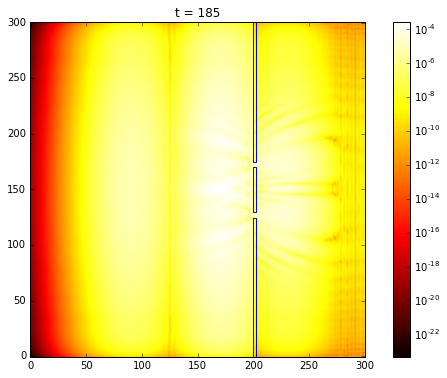

In [25]:
for i in range(10):
    t = 5+20*i
    evolv = timePropagator(psList, t = t, hNorm = hNorm)     
    plotWavefunction(transformWavetoMatrix(evolv, N, M), norm = False, 
              save = False, fileName="plots/2logPlot_" + str(t).zfill(3) +  ".png",
              title = "t = " + str(t).zfill(3), extraDraw = potParams, 
              plotOnlyRight = False, rightValue = 82, plotLog = True)
    

### Way to create GIF from the PNG files:
convert -delay 20 -loop 0 *.png animated.gif